- Version 0.1 using cp.dot for forward pass as this is a non-batched matrix operation which crashes on the cuBLAS pure GPU version (fixing it involves using host-device transfers which are slower; also, the results were wrong)
- version 0.2 using revamped tensor_matrix_multipy from tensor8.so to enable pure GPU processing with the cuBLAS kernel and cupy. much faster. code is cleaner. accuracy is still not normal but this is likely due to a step in the training process not matching cupy.
- version 0.2 fixed forward pass; we needed to use tensor_ops.batched_matmul for the layer 1 and matmul for layer 2! (was using non-batched in error). All tensor8 kernels now work accurately and do not crash!

In [1]:
# load data and define variables using cupy not numpy (keep on GPU not host); adopted from Numpy example at numpy website
import cupy as cp
import requests
import os
import gzip

data_sources = {
    "training_images": "train-images-idx3-ubyte.gz",  # 60,000 training images.
    "test_images": "t10k-images-idx3-ubyte.gz",  # 10,000 test images.
    "training_labels": "train-labels-idx1-ubyte.gz",  # 60,000 training labels.
    "test_labels": "t10k-labels-idx1-ubyte.gz",  # 10,000 test labels.
}

headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:10.0) Gecko/20100101 Firefox/10.0"
}
request_opts = {
    "headers": headers,
    "params": {"raw": "true"},
}

data_dir = "../_data"
os.makedirs(data_dir, exist_ok=True)

base_url = "https://github.com/rossbar/numpy-tutorial-data-mirror/blob/main/"

for fname in data_sources.values():
    fpath = os.path.join(data_dir, fname)
    if not os.path.exists(fpath):
        print("Downloading file: " + fname)
        resp = requests.get(base_url + fname, stream=True, **request_opts)
        resp.raise_for_status()  # Ensure download was successful
        with open(fpath, "wb") as fh:
            for chunk in resp.iter_content(chunk_size=128):
                fh.write(chunk)

mnist_dataset = {}

# Images (load to CPU then transfer to GPU)
for key in ("training_images", "test_images"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = cp.asarray(
            cp.frombuffer(mnist_file.read(), cp.uint8, offset=16).reshape(-1, 28 * 28)
        )
# Labels (load to CPU then transfer to GPU)
for key in ("training_labels", "test_labels"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = cp.asarray(
            cp.frombuffer(mnist_file.read(), cp.uint8, offset=8)
        )

x_train, y_train, x_test, y_test = (
    mnist_dataset["training_images"],
    mnist_dataset["training_labels"],
    mnist_dataset["test_images"],
    mnist_dataset["test_labels"],
)
print(
    "The shape of training images: {} and training labels: {}".format(
        x_train.shape, y_train.shape
    )
)
print(
    "The shape of test images: {} and test labels: {}".format(
        x_test.shape, y_test.shape
    )
)


training_sample, test_sample = 1000, 1000
# After getting initial subsample
training_images = x_train[0:training_sample]
# After normalization
training_images = training_images.astype(cp.float64) / 255
# After transpose
training_images = cp.asfortranarray(training_images.T)
test_images = x_test[0:test_sample].astype(cp.float64) / 255

def one_hot_encoding(labels, dimension=10):
    # Define a one-hot variable for an all-zero vector
    # with 10 dimensions (number labels from 0 to 9).
    one_hot_labels = labels[..., None] == cp.arange(dimension)[None]
    # Return one-hot encoded labels.
    return one_hot_labels.astype(cp.float64)

# Define ReLU that returns the input if it's positive and 0 otherwise (CuPy version).
def relu(x):
    return cp.maximum(0, x)

# Set up a derivative of the ReLU function that returns 1 for a positive input
# and 0 otherwise (CuPy version).
def relu2deriv(output):
    return (output >= 0).astype(cp.float64)

training_labels = one_hot_encoding(y_train[:training_sample])
test_labels = one_hot_encoding(y_test[:test_sample])
print("Training images on GPU:", training_images.device)
print("Training labels on GPU:", training_labels.device)

The shape of training images: (60000, 784) and training labels: (60000,)
The shape of test images: (10000, 784) and test labels: (10000,)
Training images on GPU: <CUDA Device 0>
Training labels on GPU: <CUDA Device 0>


In [2]:
# cuBLAS Fortran tensor core python wrapper
import numpy as np
import cupy as cp
import ctypes
from ctypes import c_int, c_double, c_void_p
import time

# load custom wrapper to make cuBLAS kernel like cupy; fortran_tensor_ops.py file must be in same directory
from fortran_tensor_ops_cupy import FortranTensorOps

# Create global instance to enable access in all cells of this notebook
tensor_ops = FortranTensorOps()

def forward_pass_tensor_ops(tensor_ops, batch_images, weights_1, weights_2, batch_size):
    """Forward pass using the new FortranTensorOps interface."""
    # First layer must use *batched* vector-matrix multiplication to replicate cp.dot (not vector_matmul)
    result_1 = tensor_ops.batched_vector_matmul(
        batch_images,  # (input_size, batch_size)
        weights_1,     # (input_size, hidden_size)
    )
    layer_1 = cp.maximum(0, result_1)  # ReLU activation

    # Second layer using tensor matmul (not batched)
    layer_2 = tensor_ops.matmul(layer_1, weights_2)
    
    return layer_1, layer_2

def forward_pass_validation(test_images, weights_1, weights_2):
    """Forward pass for validation using standard matrix multiplication"""
    # Transpose test images to match previous implementation
    test_images_t = test_images.T  # Shape: (1000, 784)
    
    # First layer
    layer_1 = test_images_t @ weights_1  # Shape: (1000, 100)
    layer_1 = cp.maximum(0, layer_1)  # ReLU activation
    
    # Second layer
    layer_2 = layer_1 @ weights_2  # Shape: (1000, 10)
    
    return layer_1, layer_2

# cupy version to compare results
def forward_pass(batch_images, weights_1, weights_2, batch_size):
    """
    Forward pass using direct cupy dot product for efficiency
    """
    # Ensure arrays are properly shaped
    batch_images_t = cp.asfortranarray(batch_images.T)  # (batch_size, input_size)
    weights_1 = cp.asfortranarray(weights_1)           # (input_size, hidden_size)
    weights_2 = cp.asfortranarray(weights_2)           # (hidden_size, output_size)
    
    # First layer
    layer_1 = cp.dot(batch_images_t, weights_1)        # (batch_size, hidden_size)
    layer_1 = cp.maximum(0, layer_1)                   # ReLU activation
    
    # Second layer
    layer_2 = cp.dot(layer_1, weights_2)               # (batch_size, output_size)
    
    return layer_1, layer_2

def update_weights(weights_1, weights_2, gradients_1, gradients_2, layer_1, learning_rate, use_cublas=False):
    """Update weights with proper memory layout handling"""
    # Ensure weights are F-contiguous
    weights_1 = cp.asfortranarray(weights_1)
    weights_2 = cp.asfortranarray(weights_2)
    
    if gradients_1 is not None and gradients_2 is not None:
        # Sum gradients across batch dimension
        grad1 = cp.sum(cp.asfortranarray(gradients_1), axis=0)
        grad2 = cp.sum(cp.asfortranarray(gradients_2), axis=0)
        
        # Update weights
        weights_1 -= learning_rate * grad1
        weights_2 -= learning_rate * grad2
        
        # Ensure outputs remain F-contiguous
        weights_1 = cp.asfortranarray(weights_1)
        weights_2 = cp.asfortranarray(weights_2)
    
    return weights_1, weights_2

def normalize_and_clip(tensor, clip_threshold):
    """Helper function to normalize and clip tensors"""
    tensor = cp.asfortranarray(tensor)
    delta_norm = cp.linalg.norm(tensor)
    if delta_norm > 1.0:
        tensor = tensor / delta_norm
    return cp.clip(tensor, -clip_threshold, clip_threshold)

def print_gradient_stats(name, gradient):
    """Helper function to print gradient statistics"""
    print(f"{name} stats:",
          f"shape: {gradient.shape}, ",
          f"min: {cp.nanmin(gradient):.6f}, ",
          f"max: {cp.nanmax(gradient):.6f}, ",
          f"mean: {cp.nanmean(gradient):.6f}, ",
          f"has_nan: {cp.isnan(gradient).any()}")
    

In [3]:
# debug routines uncomment print statements for detailed debug info
import cupy as cp
import numpy as np

def debug_data_preparation(training_images, training_labels):
    """
    Debugs initial data preparation and initial checks
    Args:
    training_images (cupy.ndarray): Input training images
    training_labels (cupy.ndarray): Input training labels
    Returns:
    tuple: Processed images and labels with debug information
    """
    #print("\nDEBUG - Initial shapes:")
    #print(f"training_images: {training_images.shape}")
    #print(f"training_labels: {training_labels.shape}")
    #print("\nDEBUG - Array properties:")
    #print(f"training_images F_CONTIGUOUS: {training_images.flags['F_CONTIGUOUS']}")
    #print(f"training_images dtype: {training_images.dtype}")
    #print(f"Sample values in training_images: {training_images[:5,0]}")
    #print(f"Any non-zero in training_images: {cp.any(training_images != 0)}")
    
    # Ensure F-contiguous layout
    training_images = cp.asfortranarray(training_images)
    training_labels = cp.asarray(training_labels)
    
    return training_images, training_labels

def debug_test_data_preparation(test_images, test_labels):
    """
    Debugs initial test data preparation and initial checks
    Args:
    test_images (cupy.ndarray): Input test images
    test_labels (cupy.ndarray): Input test labels
    Returns:
    tuple: Processed test images and labels with debug information
    """
    #print("\nDEBUG - Initial test data shapes:")
    #print(f"test_images: {test_images.shape}")
    #print(f"test_labels: {test_labels.shape}")
    #print("\nDEBUG - Test array properties:")
    #print(f"test_images F_CONTIGUOUS: {test_images.flags['F_CONTIGUOUS']}")
    #print(f"test_images dtype: {test_images.dtype}")
    #print(f"Sample values in test_images: {test_images[:5,0]}")
    #print(f"Any non-zero in test_images: {cp.any(test_images != 0)}")
    
    # Ensure F-contiguous layout and transpose
    test_images = cp.asfortranarray(test_images.T)
    test_labels = cp.asarray(test_labels)
    
    return test_images, test_labels

def debug_data_shuffling(training_images, training_labels):
    """
    Debug data shuffling mechanism
    
    Args:
        training_images (cupy.ndarray): Input training images
        training_labels (cupy.ndarray): Input training labels
    
    Returns:
        tuple: Shuffled images and labels
    """
    # Shuffle training data while maintaining F-contiguous layout
    indices = cp.random.permutation(training_images.shape[1])
    shuffled_images = cp.asfortranarray(training_images[:, indices])
    shuffled_labels = training_labels[indices]
    
    #print("\nDEBUG - Shuffling:")
    #print(f"Original images shape: {training_images.shape}")
    #print(f"Shuffled images shape: {shuffled_images.shape}")
    #print(f"Original labels shape: {training_labels.shape}")
    #print(f"Shuffled labels shape: {shuffled_labels.shape}")
    
    return shuffled_images, shuffled_labels

def debug_batch_preparation(training_images, training_labels, batch_size=64):
    """
    Debug batch preparation mechanism with enhanced error checking and memory management
    
    Args:
        training_images (cupy.ndarray): Input training images
        training_labels (cupy.ndarray): Input training labels
        batch_size (int): Size of each training batch
    
    Returns:
        tuple: First batch of images and labels with debug info
    """
    # Validate inputs
    if not isinstance(training_images, cp.ndarray):
        raise TypeError(f"training_images must be a cupy.ndarray, got {type(training_images)}")
    
    if not isinstance(training_labels, cp.ndarray):
        raise TypeError(f"training_labels must be a cupy.ndarray, got {type(training_labels)}")
    
    # Check memory usage
    total_images = training_images.shape[1]
    try:
        training_images_memory = training_images.nbytes / (1024 * 1024)  # MB
        labels_memory = training_labels.nbytes / (1024 * 1024)  # MB
        
        #print("\nDEBUG - Memory Usage:")
        #print(f"Training images memory: {training_images_memory:.2f} MB")
        #print(f"Training labels memory: {labels_memory:.2f} MB")
        #print(f"Total memory for dataset: {(training_images_memory + labels_memory):.2f} MB")
    except Exception as mem_error:
        print(f"Could not calculate memory usage: {mem_error}")
    
    # Batch preparation diagnostics
    num_batches = total_images // batch_size
    remaining_images = total_images % batch_size
    
    #print("\nDEBUG - Batch Preparation:")
    #print(f"Total batches: {num_batches}")
    #print(f"Total images: {total_images}")
    #print(f"Batch size: {batch_size}")
    #print(f"Remaining images after batching: {remaining_images}")
    
    # Verify image and label dimensions
    if training_images.ndim != 2:
        raise ValueError(f"Expected 2D training images, got {training_images.ndim}D")
    
    if training_labels.ndim != 1 and training_labels.ndim != 2:
        raise ValueError(f"Expected 1D or 2D training labels, got {training_labels.ndim}D")
    
    # Validate batch preparation can proceed
    if total_images < batch_size:
        print("WARNING: Batch size larger than total images. Using entire dataset.")
        batch_images = training_images
        batch_labels = training_labels
    else:
        # Get first batch
        try:
            batch_images = training_images[:, 0:batch_size]
            batch_labels = training_labels[0:batch_size] if training_labels.ndim == 1 else training_labels[0:batch_size, :]
        except Exception as batch_error:
            print(f"Error extracting batch: {batch_error}")
            raise
    
    #print("\nBatch Details:")
    #print(f"Batch images shape: {batch_images.shape}")
    #print(f"Batch labels shape: {batch_labels.shape}")
    
    # Additional type and memory checks
    #print("\nAdditional Diagnostics:")
    #print(f"Batch images dtype: {batch_images.dtype}")
    #print(f"Batch labels dtype: {batch_labels.dtype}")
    #print(f"Batch images memory: {batch_images.nbytes / (1024 * 1024):.2f} MB")
    #print(f"Batch labels memory: {batch_labels.nbytes / (1024 * 1024):.2f} MB")
    
    # Check for any NaN or Inf values
    try:
        print(f"NaN in batch images: {cp.isnan(batch_images).any()}")
        print(f"Inf in batch images: {cp.isinf(batch_images).any()}")
        print(f"NaN in batch labels: {cp.isnan(batch_labels).any()}")
        print(f"Inf in batch labels: {cp.isinf(batch_labels).any()}")
    except Exception as nan_check_error:
        print(f"Could not perform NaN/Inf check: {nan_check_error}")
    
    return batch_images, batch_labels

def debug_error_calculation(layer_2, batch_labels):
    """Error calculation with shape validation"""
    #print(f"Shape debug - layer_2: {layer_2.shape}, batch_labels: {batch_labels.shape}")
    
    # Ensure consistent shapes
    if layer_2.shape != batch_labels.shape:
        # Transform to match if needed
        batch_labels = cp.asfortranarray(batch_labels)
    
    error = layer_2 - batch_labels
    error = cp.asfortranarray(error)
    
    return error

# cupy version; we have no tensor core cp.outer version (no speedups likely); so use cupy version
# We need to convert this to return arrays instead of lists:
def debug_backpropagation_shapes(error, layer_1, weights_1, weights_2, batch_images, batch_size):
    """Debug backpropagation mechanism with strict gradient stabilization"""
    clip_threshold = 1.0
    
    # Delta calculations with gradient stabilization
    layer_2_delta = cp.asfortranarray(error)
    
    # Normalize before backward pass
    delta_norm = cp.linalg.norm(layer_2_delta)
    if delta_norm > 1.0:
        layer_2_delta = layer_2_delta / delta_norm
    layer_2_delta = cp.clip(layer_2_delta, -clip_threshold, clip_threshold)
    
    # First backprop step
    layer_1_delta = cp.dot(layer_2_delta, weights_2.T)
    delta_norm = cp.linalg.norm(layer_1_delta)
    if delta_norm > 1.0:
        layer_1_delta = layer_1_delta / delta_norm
    layer_1_delta = cp.multiply(layer_1_delta, (layer_1 > 0))
    layer_1_delta = cp.clip(layer_1_delta, -clip_threshold, clip_threshold)
    
    # Pre-allocate arrays for gradients
    gradients_1 = cp.empty((batch_size, batch_images.shape[0], layer_1_delta.shape[1]), dtype=cp.float64)
    gradients_2 = cp.empty((batch_size, layer_1.shape[1], layer_2_delta.shape[1]), dtype=cp.float64)
    
    for i in range(batch_size):
        grad_1 = cp.outer(batch_images[:,i], layer_1_delta[i])
        grad_2 = cp.outer(layer_1[i], layer_2_delta[i])
        
        # Normalize gradients
        for grad in [grad_1, grad_2]:
            norm = cp.linalg.norm(grad)
            if norm > 1.0:
                grad /= norm
                
        grad_1 = cp.clip(grad_1, -clip_threshold, clip_threshold)
        grad_2 = cp.clip(grad_2, -clip_threshold, clip_threshold)
        
        gradients_1[i] = grad_1
        gradients_2[i] = grad_2

    # Return F-contiguous arrays
    return cp.asfortranarray(gradients_1), cp.asfortranarray(gradients_2)

# track statistics
class TrainingTracker:
    def __init__(self, epochs):
        """
        Initialize tracking for training progression
        
        Args:
            epochs (int): Total number of training epochs
        """
        # Storage for metrics
        self.training_loss = []
        self.training_accurate_pred = []
        self.test_loss = []
        self.test_accurate_pred = []
    
    def store_epoch_metrics(self, 
                             training_loss, 
                             training_accurate_predictions, 
                             test_loss, 
                             test_accurate_predictions,
                             training_images_length,
                             test_images_length):
        """
        Store metrics for a single epoch
        
        Args:
            training_loss (float): Total training loss for the epoch
            training_accurate_predictions (float): Number of accurate predictions in training
            test_loss (float): Total test loss for the epoch
            test_accurate_predictions (float): Number of accurate predictions in test set
            training_images_length (int): Number of training images
            test_images_length (int): Number of test images
        """
        # Store normalized metrics
        self.training_loss.append(float(training_loss / training_images_length))
        self.training_accurate_pred.append(float(training_accurate_predictions / training_images_length))
        self.test_loss.append(float(test_loss / test_images_length))
        self.test_accurate_pred.append(float(test_accurate_predictions / test_images_length))
    
    def print_epoch_summaries(self):
        """
        Print summaries for all epochs
        """
        for j in range(len(self.training_loss)):
            print(
                f"Epoch: {j}\n"
                f"  Training set error: {self.training_loss[j]:.3f}\n"
                f"  Training set accuracy: {self.training_accurate_pred[j]:.3f}\n"
                f"  Test set error: {self.test_loss[j]:.3f}\n"
                f"  Test set accuracy: {self.test_accurate_pred[j]:.3f}"
            )

    def get_metrics(self):
        """
        Return all stored metrics
        
        Returns:
            dict: Dictionary containing all stored metrics
        """
        return {
            'training_loss': self.training_loss,
            'training_accurate_pred': self.training_accurate_pred,
            'test_loss': self.test_loss,
            'test_accurate_pred': self.test_accurate_pred
        }   

In [25]:
# Training loop refactored with tensor_ops but based on numpy reference structure

print("initialize parameters")
seed = 884736743
rng = cp.random.default_rng(seed)
learning_rate = 0.005
hidden_size = 100
pixels_per_image = input_size = 784
num_labels = output_size = 10
batch_size = 256
gradient_clipping_norm = 1.0
num_epochs = 200
epochs = num_epochs
tracker = TrainingTracker(num_epochs)

# Initialize tensor ops (needed for cuBLAS Fortran tensor core accelerated kernels)
tensor_ops = FortranTensorOps()

# Create the array without specifying the order
weights_1_non_contiguous = 0.2 * rng.random((pixels_per_image, hidden_size), dtype=cp.float64) - 0.1
weights_2_non_contiguous = 0.2 * rng.random((hidden_size, num_labels), dtype=cp.float64) - 0.1

# Convert the array to Fortran contiguous
weights_1 = cp.asfortranarray(weights_1_non_contiguous)
weights_2 = cp.asfortranarray(weights_2_non_contiguous)

# Process and prepare data once, before training starts
processed_training_images, processed_training_labels = debug_data_preparation(
    training_images, training_labels)
processed_test_images, processed_test_labels = debug_test_data_preparation(
    test_images, test_labels)

# Calculate number of batches once
num_batches = processed_training_images.shape[1] // batch_size

# Epoch loop
for epoch in range(num_epochs):
    # Reset epoch-level tracking variables
    total_training_loss = 0.0
    total_training_accurate_predictions = 0
    
    # Shuffle data for this epoch
    shuffled_images, shuffled_labels = debug_data_shuffling(
        processed_training_images, processed_training_labels)
    
    # Batch processing loop
    for batch in range(num_batches):
        # Prepare batch
        start_idx = batch * batch_size
        end_idx = start_idx + batch_size
        batch_images = shuffled_images[:, start_idx:end_idx]
        batch_labels = shuffled_labels[start_idx:end_idx]
        
        # Forward pass using tensor ops; needed to use batched_matmul, not matmul!!
        layer_1, layer_2 = forward_pass_tensor_ops(
            tensor_ops, batch_images, weights_1, weights_2, batch_size
        )
        # Forward pass cupy version for comparison of accuracy and speed
        #layer_1, layer_2 = forward_pass(
        #   batch_images, weights_1, weights_2, batch_images.shape[1])

        # In training forward pass
        #print("Training input shapes:")
        #print("batch_images_t shape:", batch_images.shape)
        #print("batch_images_t is_c_contiguous:", batch_images.flags.c_contiguous)
        #print("batch_images_t is_f_contiguous:", batch_images.flags.f_contiguous)
        
        # Calculate error (using existing function)
        error = debug_error_calculation(layer_2, batch_labels)
        #print("Error stats:", 
        #    "min:", cp.nanmin(error),
        #    "max:", cp.nanmax(error),
        #    "has_nan:", cp.isnan(error).any())
        
        # Backpropagation using tensor ops
        gradients_1, gradients_2 = debug_backpropagation_shapes(
            error, layer_1, weights_1, weights_2, 
            batch_images, batch_size)
        
        # Update weights
        weights_1, weights_2 = update_weights(
            weights_1, weights_2, 
            gradients_1, gradients_2,
            layer_1,
            learning_rate,
            use_cublas=True)                        # Since we're using tensor ops

        #print("Error tensor before sum:", error.shape, error.dtype, error.flags)
        #print("Is error contiguous?", error.flags.c_contiguous)
        #print("First few values:", error[:5] if error.size > 0 else "empty")
        
        # Accumulate batch metrics
        batch_loss = float(cp.sum(error ** 2))
        total_training_loss += batch_loss
        batch_accurate_predictions = cp.sum(
            cp.argmax(layer_2, axis=1) == cp.argmax(batch_labels, axis=1))
        total_training_accurate_predictions += batch_accurate_predictions
    
    # Validation on test set using cupy works but not tensor ops; do non-match here
    #test_layer_1, test_layer_2 = forward_pass(
    #    processed_test_images, weights_1, weights_2, processed_test_images.shape[1])
    test_layer_1, test_layer_2 = forward_pass_validation(
        processed_test_images, weights_1, weights_2)
    test_layer_2 = test_layer_2  # Shape: (1000, 10)
    test_error = processed_test_labels - test_layer_2
    test_loss = float(cp.sum(test_error ** 2))
    test_accurate_predictions = cp.sum(
        cp.argmax(test_layer_2, axis=1) == cp.argmax(processed_test_labels, axis=1))

    # Store metrics
    tracker.store_epoch_metrics(
        total_training_loss,
        total_training_accurate_predictions,
        test_loss,
        test_accurate_predictions,
        len(training_images),
        len(test_images))

# Print final summaries
tracker.print_epoch_summaries()
# 6.8s on cuBLAS tensor kernels (before CUDA stream optimisation) A1000 GPU; .796 test set accuracy 20 epochs
# 5.5s with 128 batch size
# 4.8s with 256 batch size

initialize parameters
 CUDA resources finalized successfully
 CUDA resources initialized successfully
 CUDA resources finalized successfully
 CUDA resources initialized successfully
 CUDA resources finalized successfully
 CUDA resources initialized successfully
 CUDA resources finalized successfully
 CUDA resources initialized successfully
 CUDA resources finalized successfully
 CUDA resources initialized successfully
 CUDA resources finalized successfully
 CUDA resources initialized successfully
 CUDA resources finalized successfully
 CUDA resources initialized successfully
 CUDA resources finalized successfully
 CUDA resources initialized successfully
 CUDA resources finalized successfully
 CUDA resources initialized successfully
 CUDA resources finalized successfully
 CUDA resources initialized successfully
 CUDA resources finalized successfully
 CUDA resources initialized successfully
 CUDA resources finalized successfully
 CUDA resources initialized successfully
 CUDA resources fi

<Figure size 640x480 with 0 Axes>

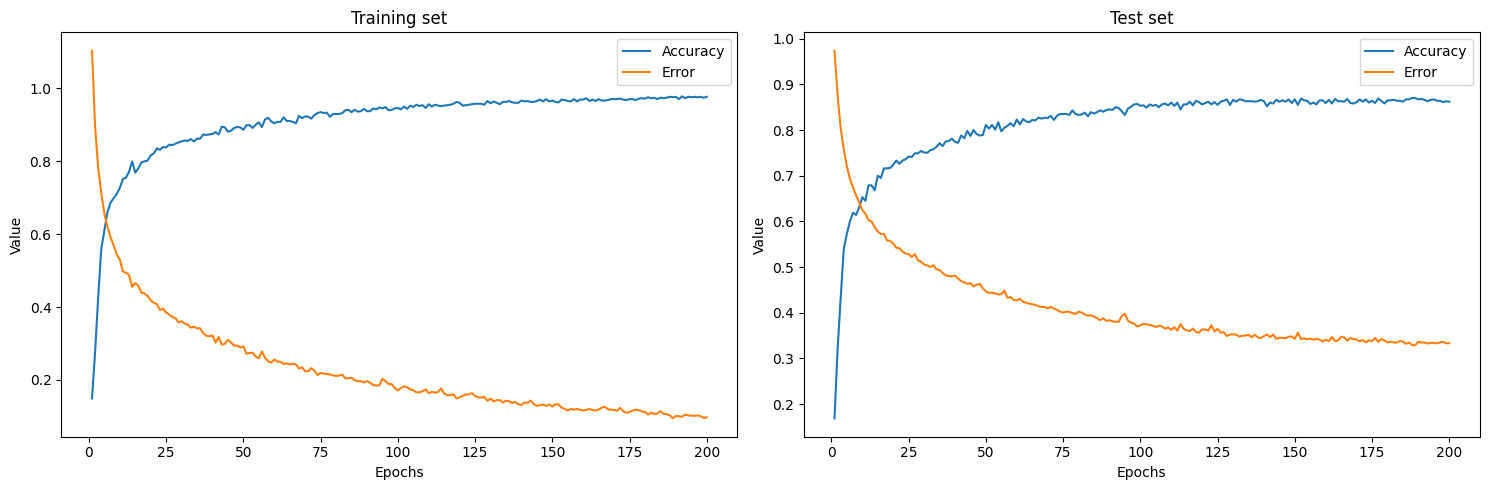

In [26]:
# display and chart should be in python
import matplotlib.pyplot as plt
import numpy as np

# Retrieve metrics from the tracker
metrics = tracker.get_metrics()

# Create epoch range
epochs = len(metrics['training_accurate_pred'])
epoch_range = np.arange(1, epochs + 1)

# The training set metrics
training_metrics = {
    "accuracy": np.array(metrics['training_accurate_pred']),
    "error": np.array(metrics['training_loss'])
}

# The test set metrics
test_metrics = {
    "accuracy": np.array(metrics['test_accurate_pred']),
    "error": np.array(metrics['test_loss'])
}

# Clear any existing plots
plt.clf()

# Create the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for ax, metrics, title in zip(
    axes, (training_metrics, test_metrics), ("Training set", "Test set")
):
    # Plot the metrics
    for metric, values in metrics.items():
        ax.plot(epoch_range, values, label=metric.capitalize())
    ax.set_title(title)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Value")
    ax.legend()

plt.tight_layout()
plt.show()

In [27]:
# added excellent FortranTensorOps wrapper, a python program in the same directory that wraps cupy like commands before sending 
# to the fortran kernel (without the need for complicated wrappers in the notebook--it works great)
# fixed training run by using batched matmul for forward pass (not tensor dot) and non-batched matmul for validation to replace cp.dot()